# Scattering of a Plane Wave from a Rigid Sphere
We seek the resultant pressure wave field in Spherical coordinates. Following the analysis of [Beranek and Mellow](https://www.amazon.com/Acoustics-Transducers-Leo-L-Beranek/dp/0123914213)
$$
    \tilde{p}(r,\theta) = \tilde{p}_I(r,\theta) + \tilde{p}_S(r,\theta)
$$
where $I$ is the incident wave and $s$ is the scattered wave.

## Notebook Imports and Configuration

In [1]:
%pylab inline
#%pylab notebook
#%matplotlib qt
import sk_dsp_comm.sigsys as ss
import scipy.signal as signal
import scipy.special as special
from IPython.display import Audio, display
from IPython.display import Image, SVG

Populating the interactive namespace from numpy and matplotlib


### Figure Rendering Options

In [2]:
pylab.rcParams['savefig.dpi'] = 100 # default 72
#pylab.rcParams['figure.figsize'] = (6.0, 4.0) # default (6,4)
#%config InlineBackend.figure_formats=['png'] # default for inline viewing
%config InlineBackend.figure_formats=['svg'] # SVG inline viewing
#%config InlineBackend.figure_formats=['pdf'] # render pdf figs for LaTeX

#### Define the Spherical Hankel Functions

In [3]:
def spherical_hn1(n,z,derivative=False):
    """ Spherical Hankel Function of the First Kind """
    return special.spherical_jn(n,z,derivative=False)+1j \
           *special.spherical_yn(n,z,derivative=False)

def spherical_hn2(n,z,derivative=False):
    """ Spherical Hankel Function of the Second Kind """
    return special.spherical_jn(n,z,derivative=False)-1j \
           *special.spherical_yn(n,z,derivative=False)

## [The Incident Plane Wave Expansion](https://en.wikipedia.org/wiki/Plane_wave_expansion)
We start with a spherical harmonics expansion of a plane wave source:
$$
    \tilde{p}_I(r,\theta) = \tilde{p}_0 \sum_{n=0}^\infty (-j)^n (2n+1) j_n(kr) P_n\big(\cos(\theta)\big)
$$
where the wavenumber $k$ is given by
$$
    k = \frac{2\pi}\lambda = \frac{2\pi}{c/f} = \frac{2\pi f}{c}\ \text{radians/m}
$$
where $c$ is the speed of sound in air, given by $344.4$ m/s at an ambient pressure of $10^5$ Pa and at $22^\circ$ C. The variable $f$ is frequency in Hz. The special functions are spherical Bessel functions of the first king, $j_n(kr)$, and the Legendre functions $P_n^m(\cos(\theta))|_{m=0} = P_n(\cos(\theta))$.

In [4]:
def pI(w, z, f, R = 1, N = 50):
    """
    
    Mark Wickert November 2018
    """
    p_0 = 1
    k = 2*pi/(344.4/f)
    p_polar = zeros((len(z),len(w)),dtype=complex128)
    for n,wn in enumerate(w):
        for m,zm in enumerate(z):
            r = sqrt(zm**2 + wn**2)
            cos_theta = zm/sqrt(zm**2 + wn**2)
            for kk in range(N+1):
                if r <= R:
                    p_polar[m,n] = 0.0
                else:
                    p_polar[m,n] += p_0*(-1j)**kk * (2*kk+1) \
                    * special.spherical_jn(kk,k*r) \
                    * special.lpmv(0,kk,cos_theta)
    return p_polar

## The Scattered Field from the Sphere
Next we move on to finding the scattered field:
$$
    \tilde{p}_S(r,\theta) = -\tilde{p}_0 \sum_{n=0}^\infty (-j)^n (2n+1)\frac{j_n^\prime(kR)}{h_n^{\prime(2)}(kR)} h_n^{(2)}(kr) P_n\big(\cos(\theta)\big)
$$
where $R$ is the sphere radius. The new special functions are spherical Hankel functions of the second kind, $h_n^{(2)}(kr)$, and their derivatives, $h_n^{\prime(2)}(kr)$.

In [5]:
def pS(w, z, f, R = 1, N = 50):
    """
    
    Mark Wickert November 2018
    """
    p_0 = 1
    k = 2*pi/(344.4/f)
    p_polar = zeros((len(z),len(w)),dtype=complex128)
    for n,wn in enumerate(w):
        for m,zm in enumerate(z):
            r = sqrt(zm**2 + wn**2)
            cos_theta = zm/sqrt(zm**2 + wn**2)
            for kk in range(N+1):
                if r <= R:
                    p_polar[m,n] = 0.0
                else:
                    p_polar[m,n] += p_0*(-1j)**kk * (2*kk+1) \
                    * special.spherical_jn(kk,k*R,True)/\
                    spherical_hn2(kk,k*R,True) \
                    * spherical_hn2(kk,k*r) \
                    * special.lpmv(0,kk,cos_theta)
    return -p_polar

### The Resultant Sound Pressure Over a Rectangular Region
Get a view of the sound pressure magnitude in a rectangular regions that includes the rigid sphere.

**Pressure Near Spherical Head at 600 Hz**

In [8]:
# Calculation is time consuming so an archive is available too
w = arange(-0.20,0.20,.001) # 005
z = arange(-0.15,0.15,0.001) #004
#pI_polar = pI(w,z,600,0.0875,50)
#pS_polar = pS(w,z,600,0.0875,50)

In [30]:
# Save the results of the above if desired. 
#savez_compressed('p_polar_600_R875',a=w,b=z,c=pI_polar,d=pS_polar)

In [10]:
# Restore from the archive to make a plot
p_600_R875 = load('p_polar_600_R875.npz')
w_600_R875 = p_600_R875['a']
z_600_R875 = p_600_R875['b']
pI_600_R875_polar = p_600_R875['c']
pS_600_R875_polar = p_600_R875['d']

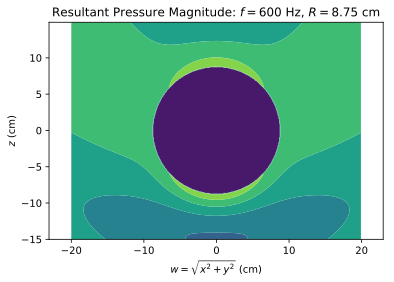

In [11]:
wM,zM = meshgrid(w,z)
contourf(wM*100,zM*100, abs(pI_600_R875_polar+pS_600_R875_polar))
title(r'Resultant Pressure Magnitude: $f=600$ Hz, $R=8.75$ cm')
ylabel(r'$z$ (cm)')
xlabel(r'$w = \sqrt{x^2 + y^2}$ (cm)')
axis('equal');
#savefig('mag_600_R375.pdf')

**Pressure Near Spherical Head at 1000 Hz**

In [34]:
w = arange(-0.20,0.20,.001) # 005
z = arange(-0.15,0.15,0.001) #004
# pI_polar = pI(w,z,1000,0.0875,50)
# pS_polar = pS(w,z,1000,0.0875,50)

In [35]:
savez_compressed('p_polar_1000_R875',a=w,b=z,c=pI_polar,d=pS_polar)

In [12]:
p_1000_R875 = load('p_polar_1000_R875.npz')
w_1000_R875 = p_600_R875['a']
z_1000_R875 = p_600_R875['b']
pI_1000_R875_polar = p_1000_R875['c']
pS_1000_R875_polar = p_1000_R875['d']

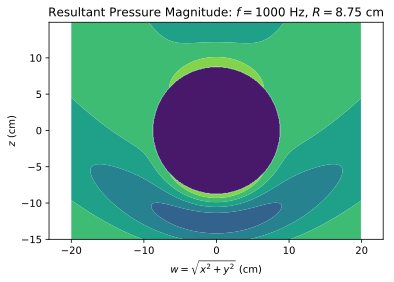

In [13]:
wM,zM = meshgrid(w,z)
contourf(wM*100,zM*100, abs(pI_1000_R875_polar+pS_1000_R875_polar))
title(r'Resultant Pressure Magnitude: $f=1000$ Hz, $R=8.75$ cm')
ylabel(r'$z$ (cm)')
xlabel(r'$w = \sqrt{x^2 + y^2}$ (cm)')
axis('equal');
#savefig('mag_1000_R375.pdf')

**Pressure Near Spherical Head at 2000 Hz**

In [39]:
w = arange(-0.20,0.20,.001) # 005
z = arange(-0.15,0.15,0.001) #004
# pI_polar = pI(w,z,2000,0.0875,50)
# pS_polar = pS(w,z,2000,0.0875,50)

In [40]:
savez_compressed('p_polar_2000_R875',a=w,b=z,c=pI_polar,d=pS_polar)

In [16]:
p_2000 = load('p_polar_2000_R875.npz')
w_2000 = p_2000['a']
z_2000 = p_2000['b']
pI_2000_R875_polar = p_2000['c']
pS_2000_R875_polar = p_2000['d']

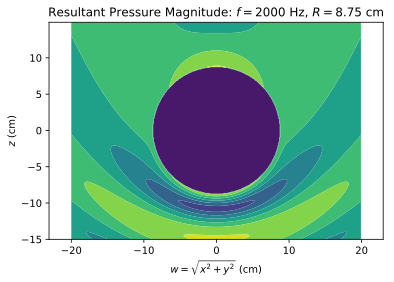

In [17]:
wM,zM = meshgrid(w,z)
contourf(wM*100,zM*100, abs(pI_2000_R875_polar+pS_2000_R875_polar))
title(r'Resultant Pressure Magnitude: $f=2000$ Hz, $R=8.75$ cm')
ylabel(r'$z$ (cm)')
xlabel(r'$w = \sqrt{x^2 + y^2}$ (cm)')
axis('equal');
#savefig('mag_2000_R375.pdf',transparent=True)